# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import normaltest

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Функции для работы

In [ ]:
df_result = pd.DataFrame()

def metrics_score(model, y_test, y_pred):
    # вычисляем взвешенные значения всех метрик
    accuracy = accuracy_score(y_test, y_pred)
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    weighted_recall = recall_score(y_test, y_pred, average='weighted')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')

    # заносим взвешенные значения метрик в датафрейм
    weighted_add = pd.DataFrame([[model,
                                  round(accuracy, 5),
                                  round(weighted_precision, 5),
                                  round(weighted_recall, 5),
                                  round(weighted_f1, 5)
                                  ]],
                                columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    # вычисляем значения метрики f1
    # для каждого класса по отдельности и заносим в датафрейм
    f1_class_add = pd.DataFrame([f1_score(y_test, y_pred, average=None)],
                                columns=['f1_0', 'f1_1'])

    # объединяем все вычисленные значения метрик
    df_add = weighted_add.join(f1_class_add)

    # вычисляем сумму элементов матрицы ошибок вне
    # главной диагонали (т.е. сумму всех ошибок классификации)
    # и добавляем в датафрейм
    cm = confusion_matrix(y_test, y_pred)
    df_add['error'] = np.sum(cm) - np.trace(cm)

    # вычисляем процентную долю суммы ошибочных значений
    # для всех классов от объема тестовой выборки и добавляем в датафрейм
    df_add['% error %'] = (df_add['error'] / len(y_test)) * 100

    # выводим результаты классификации
    print(classification_report(y_test, y_pred_test))
    fig, ax = plt.subplots()
    ax = sns.heatmap(confusion_matrix(y_test, y_pred_test), annot = True)

    # выводим обновленную таблицу результатов
    # (с добавленной строкой значений метрик и
    # количеством ошибочных значений)
    return pd.concat([df_result, df_add], ignore_index=True)

In [ ]:
def grid_results(grid):
    grid_table = pd.DataFrame(grid.cv_results_)
    grid_table_rank = grid_table[['params',
                                  'mean_test_score',
                                  'std_test_score',
                                  'rank_test_score']] \
                                  .loc[grid_table['rank_test_score']==1] \
                                  .sort_values(by='std_test_score', ascending=True)

    print("The best value = {} with {} of accuracy.".format(grid.best_params_,grid.best_score_))

    print("The best value = {}, highest mean accuracy along with the cross validation = {} and lowest standard deviation = {}" \
    .format(grid_table.at[grid.best_index_,'params'],
            grid_table.at[grid.best_index_,'mean_test_score'],
            grid_table.at[grid.best_index_,'std_test_score']))

    print("The best classifier is: {}".format(grid.best_estimator_))

# Предобработка данных

In [4]:
data = pd.read_csv("drive/MyDrive/smoking_driking_dataset_Ver01.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991346 entries, 0 to 991345
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               991346 non-null  object 
 1   age               991346 non-null  int64  
 2   height            991346 non-null  int64  
 3   weight            991346 non-null  int64  
 4   waistline         991346 non-null  float64
 5   sight_left        991346 non-null  float64
 6   sight_right       991346 non-null  float64
 7   hear_left         991346 non-null  float64
 8   hear_right        991346 non-null  float64
 9   SBP               991346 non-null  float64
 10  DBP               991346 non-null  float64
 11  BLDS              991346 non-null  float64
 12  tot_chole         991346 non-null  float64
 13  HDL_chole         991346 non-null  float64
 14  LDL_chole         991346 non-null  float64
 15  triglyceride      991346 non-null  float64
 16  hemoglobin        99

In [5]:
# категориальные признаки преобразовываем в бинарные
data.replace({'sex': {'Male': 0, 'Female': 1}}, inplace = True)
data.replace({'DRK_YN':{'N': 0, 'Y': 1}}, inplace = True)

# Построение признаков

## Пропущенные значения

In [ ]:
data.isnull().sum()

sex                 0
age                 0
height              0
weight              0
waistline           0
sight_left          0
sight_right         0
hear_left           0
hear_right          0
SBP                 0
DBP                 0
BLDS                0
tot_chole           0
HDL_chole           0
LDL_chole           0
triglyceride        0
hemoglobin          0
urine_protein       0
serum_creatinine    0
SGOT_AST            0
SGOT_ALT            0
gamma_GTP           0
SMK_stat_type_cd    0
DRK_YN              0
dtype: int64

Пропущенных значений нет, все хорошо.

## Выбросы

In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sex,991346.0,0.468990,0.499038,0.0,0.0,0.0,1.0,1.0
age,991346.0,47.614491,14.181339,20.0,35.0,45.0,60.0,85.0
height,991346.0,162.240625,9.282957,130.0,155.0,160.0,170.0,190.0
weight,991346.0,63.284050,12.514241,25.0,55.0,60.0,70.0,140.0
waistline,991346.0,81.233358,11.850323,8.0,74.1,81.0,87.8,999.0
sight_left,991346.0,0.980834,0.605949,0.1,0.7,1.0,1.2,9.9
sight_right,991346.0,0.978429,0.604774,0.1,0.7,1.0,1.2,9.9
hear_left,991346.0,1.031495,0.174650,1.0,1.0,1.0,1.0,2.0
hear_right,991346.0,1.030476,0.171892,1.0,1.0,1.0,1.0,2.0
SBP,991346.0,122.432498,14.543148,67.0,112.0,120.0,131.0,273.0


Есть подозрения на выбросы по колонкам.

с обоих сторон (разрывы min-25%, 75%-max):
- weight
- waistline
- SBP
- DBP
- BLDS
- tot_chole
- HDL_chole
- LDL_chole
- triglyceride
- hemoglobin
- SGOT_AST
- SGOT_ALT
- gamma_GPT

с одной стороны (разрыв 75%-max):
- sight_left
- sight_right
- urine_protein
- serum_creatinine

Используем изолирующий лес.


In [ ]:
print("Размер датасета до удаления выбросов: ", data.shape)

# идентифицируем выбросы
iso = IsolationForest()
y_outliers = iso.fit_predict(data)
indices = []
for i in range(len(y_outliers)):
    if y_outliers[i] == -1:
      indices.append(i);
# удаляем выбросы
print("Будет удалено: ", len(indices), "записей")
data_copy = data[~data.index.isin(indices)]
print("Размер после до удаления выбросов: ", data_copy.shape)

Размер датасета до удаления выбросов:  (991346, 24)
Будет удалено:  54951 записей
Размер после до удаления выбросов:  (936395, 24)


In [ ]:
data_copy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sex,936395.0,0.476252,0.499436,0.0,0.0,0.0,1.0,1.0
age,936395.0,47.097758,13.868843,20.0,35.0,45.0,55.0,85.0
height,936395.0,162.289589,9.191341,130.0,155.0,160.0,170.0,190.0
weight,936395.0,63.056168,12.168931,25.0,55.0,60.0,70.0,140.0
waistline,936395.0,80.874183,11.447213,27.0,74.0,81.0,87.0,999.0
sight_left,936395.0,0.978810,0.520941,0.1,0.7,1.0,1.2,9.9
sight_right,936395.0,0.976068,0.518930,0.1,0.7,1.0,1.2,9.9
hear_left,936395.0,1.013916,0.117143,1.0,1.0,1.0,1.0,2.0
hear_right,936395.0,1.012023,0.108987,1.0,1.0,1.0,1.0,2.0
SBP,936395.0,121.921807,14.146258,70.0,111.0,120.0,130.0,273.0


Улучшилась ситуация:
- waistline (нижняя граница)
- HDL_chole (верхняя граница)
- LDL_chole (верхняя граница)
- triglyceride (верхняя граница)
- SGOT_AST (верхняя граница)
- SGOT_ALT (верхняя граница)

Но все равно остались большие разбежки в значениях между 75% и max.

Попробуем определение границы выбросов при помощи межквартильного размаха.

In [ ]:
print("Размер датасета до удаления выбросов: ", data.shape)

columns = {'weight', 'waistline', 'SBP', 'DBP', 'BLDS', 'tot_chole',
                   'HDL_chole', 'LDL_chole', 'triglyceride', 'hemoglobin',
                   'SGOT_AST', 'SGOT_ALT', 'gamma_GTP', 'sight_left',
                   'sight_right', 'urine_protein', 'serum_creatinine'}
q1s = {}
q3s = {}
iqrs = {}
k = 1.5
for column in columns:
    # Считаем первый и третий квантили
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    # И межквартильный размах
    iqr = q3 - q1
    q1s[column] = q1
    q3s[column] = q3
    iqrs[column] = iqr
data_copy = data
for column in columns:
  data_copy = data_copy.drop(data_copy[((data_copy[column] > (q3s[column] + k * iqrs[column])) | (data_copy[column] < (q1s[column] - k * iqrs[column])))].index)
print("Будет удалено: ", len(data) - len(data_copy), "записей")

print("Размер датасета после удаления выбросов: ", data_copy.shape)

Размер датасета до удаления выбросов:  (991346, 24)
Будет удалено:  323563 записей
Размер датасета после удаления выбросов:  (667783, 24)


In [ ]:
data_copy.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sex,667783.0,0.530813,0.499050,0.0,0.0,1.0,1.0,1.0
age,667783.0,47.088478,14.332858,20.0,35.0,45.0,55.0,85.0
height,667783.0,161.528386,9.149305,130.0,155.0,160.0,170.0,190.0
weight,667783.0,61.139637,11.005718,35.0,55.0,60.0,70.0,90.0
waistline,667783.0,79.372442,8.828038,53.6,73.0,79.8,85.6,108.3
sight_left,667783.0,0.946228,0.326951,0.1,0.7,1.0,1.2,1.9
sight_right,667783.0,0.944130,0.326675,0.1,0.7,1.0,1.2,1.9
hear_left,667783.0,1.029661,0.169650,1.0,1.0,1.0,1.0,2.0
hear_right,667783.0,1.028641,0.166796,1.0,1.0,1.0,1.0,2.0
SBP,667783.0,120.237064,13.101011,84.0,110.0,120.0,130.0,159.0


Ситуация стала гораздо лучше, хотя пришлось пожертвовать третью датасета.
Поскольку не было уверенности в том, что это опечатка, а не аномальные значения, было принято решение не заменять их.

In [ ]:
data = data_copy

## Неинформативные признаки

In [ ]:
num_rows = len(data.index)
low_information_cols = [] #

for col in data.columns:
    cnts = data[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]

    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

hear_left: 97.03392%
1.0    647976
2.0     19807
Name: hear_left, dtype: int64

hear_right: 97.13590%
1.0    648657
2.0     19126
Name: hear_right, dtype: int64

urine_protein: 100.00000%
1.0    667783
Name: urine_protein, dtype: int64



Признаки не несут никакой полезной информации, можем удалить их.

In [ ]:
data = data.drop(columns=['hear_left', 'hear_right', 'urine_protein'])

## Нерелевантные записи

Таких в данном случая нет 😸

## Дубликаты записей

In [ ]:
data = data.drop_duplicates()

## Масштабирование

In [ ]:
scaler = MinMaxScaler()
data_copy = scaler.fit_transform(data)
data = pd.DataFrame(data_copy,columns=data.columns)
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sex,667769.0,0.530814,0.499050,0.0,0.000000,1.000000,1.000000,1.0
age,667769.0,0.416746,0.220505,0.0,0.230769,0.384615,0.538462,1.0
height,667769.0,0.525473,0.152488,0.0,0.416667,0.500000,0.666667,1.0
weight,667769.0,0.475265,0.200104,0.0,0.363636,0.454545,0.636364,1.0
waistline,667769.0,0.471159,0.161390,0.0,0.354662,0.478976,0.585009,1.0
sight_left,667769.0,0.470127,0.181640,0.0,0.333333,0.500000,0.611111,1.0
sight_right,667769.0,0.468961,0.181486,0.0,0.333333,0.500000,0.611111,1.0
SBP,667769.0,0.483160,0.174680,0.0,0.346667,0.480000,0.613333,1.0
DBP,667769.0,0.472711,0.186606,0.0,0.354167,0.479167,0.583333,1.0
BLDS,667769.0,0.477056,0.167100,0.0,0.358209,0.462687,0.567164,1.0


## Деление на X и y

In [6]:
X = data.iloc[:, :20]
y = data.iloc[:, -1]
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 991346 entries, 0 to 991345
Series name: DRK_YN
Non-Null Count   Dtype
--------------   -----
991346 non-null  int64
dtypes: int64(1)
memory usage: 7.6 MB


# Отбор признаков

**Метод фильтрации (Сбор информации)**

Оценка информационного прироста каждой переменной в контексте целевой.

In [7]:
import_feat = mutual_info_classif(X, y, n_neighbors=10, random_state=42)
f_mic = pd.DataFrame({'features': X.columns, 'importance': import_feat})

# добавляем кумулятивный столбец для наглядности
sum_import = f_mic['importance'].sum()
f_mic['importance'] = f_mic['importance'].apply(lambda x: x/sum_import*100)
f_mic = f_mic.sort_values('importance', ascending=False).reset_index(drop=True)
f_mic['cusum_importance'] = f_mic['importance'].cumsum(axis=0)

f_mic

KeyboardInterrupt: 

Для получения объема взаимной информации с целевой переменной в 95% необходимо испозовать 10 первых признаков из таблицы.

## Удаление лишних признаков

In [ ]:
X_short = X.drop(columns=['waistline', 'DBP', 'HDL_chole', 'SBP',
                          'LDL_chole', 'tot_chole', 'SGOT_AST', 'SGOT_ALT',
                          'triglyceride', 'BLDS'])

X_short.describe().transpose()
y_short = y

# Классификация с классическим подходом

## Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = \
train_test_split(X_short, y_short, train_size = 0.7, test_size = 0.3, random_state = 100)

cols = X_train.columns

## kNN

              precision    recall  f1-score   support

         0.0       0.69      0.68      0.69    106999
         1.0       0.64      0.64      0.64     93332

    accuracy                           0.67    200331
   macro avg       0.66      0.66      0.66    200331
weighted avg       0.67      0.67      0.67    200331



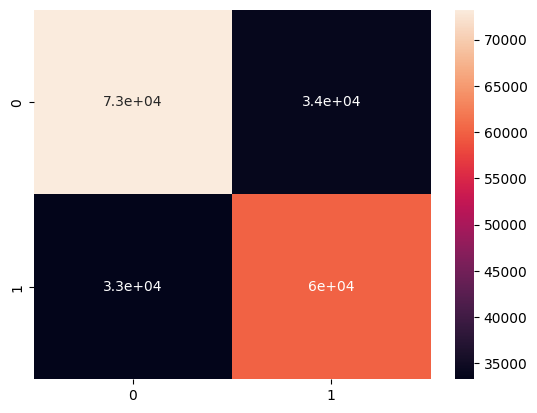

In [ ]:
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)

df_result = metrics_score('KNN', y_test, y_pred_test)

**Подбор гиперпараметра**

Для k = (1, 3) время работы 18:18, результаты:


> The best value of k = {'n_neighbors': 2} with 0.6251458205394492 of accuracy.

> The best k value, rank 1, with k = {'n_neighbors': 2}, highest mean accuracy along with the cross validation = 0.6251458205394492 and lowest standard deviation = 0.0004013653935464922

> The best classifier is: KNeighborsClassifier(n_neighbors=2)

Для k = (4, 6) время работы 27:09, результаты:

> The best value of k = {'n_neighbors': 5} with 0.6672936304791842 of accuracy.

> The best k value, rank 1, with k = {'n_neighbors': 5}, highest mean accuracy along with the cross validation = 0.6672936304791842 and lowest standard deviation = 0.00048578512802765773

> The best classifier is: KNeighborsClassifier()

Для k = (7, 9) время работы 28:35, результаты:

> The best value = {'n_neighbors': 7} with 0.6767729568107307 of accuracy.

> The best value = {'n_neighbors': 7}, highest mean accuracy along with the cross validation = 0.6767729568107307 and lowest standard deviation = 0.0005066333784632295

> The best classifier is: KNeighborsClassifier(n_neighbors=7)

Для k = (10, 12) время работы 31:47, результаты:

> The best value = {'n_neighbors': 11} with 0.6867554512750714 of accuracy.

> The best value = {'n_neighbors': 11}, highest mean accuracy along with the cross validation = 0.6867554512750714 and lowest standard deviation = 0.000666490818211108

> The best classifier is: KNeighborsClassifier(n_neighbors=11)

Для k = (13, 15) время работы 35:00, результаты:

> The best value = {'n_neighbors': 14} with 0.6896232098114748 of accuracy.

> The best value = {'n_neighbors': 14}, highest mean accuracy along with the cross validation = 0.6896232098114748 and lowest standard deviation = 0.0008562803790390207

> The best classifier is: KNeighborsClassifier(n_neighbors=14)

Для k = (16, 18) время работы 35:57, результаты:

> The best value = {'n_neighbors': 17} with 0.6939330837225072 of accuracy.

> The best value = {'n_neighbors': 17}, highest mean accuracy along with the cross validation = 0.6939330837225072 and lowest standard deviation = 0.001040882574474005

Для k = (19; 21; 23) время работы 1:09:06, результаты:

> The best classifier is: KNeighborsClassifier(n_neighbors=17)

> The best value = {'n_neighbors': 23} with 0.6977667440957033 of accuracy.

> The best value = {'n_neighbors': 23}, highest mean accuracy along with the cross validation = 0.6977667440957033 and lowest standard deviation = 0.0006867411970391539

> The best classifier is: KNeighborsClassifier(n_neighbors=23)

Максимум, который удалось добиться - при n_neighbors=100 accuracy ~0.70

In [ ]:
k_list = list(range(4,6))
k_values = dict(n_neighbors=k_list)

grid = GridSearchCV(knn, k_values, cv=3, scoring='accuracy')
grid.fit(X_short, y_short)

grid_results(grid)

The best value of k = {'n_neighbors': 5} with 0.6672936304791842 of accuracy.
The best k value, rank 1, with k = {'n_neighbors': 5}, highest mean accuracy along with the cross validation = 0.6672936304791842 and lowest standard deviation = 0.00048578512802765773
The best classifier is: KNeighborsClassifier()


              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72    106999
         1.0       0.68      0.69      0.69     93332

    accuracy                           0.71    200331
   macro avg       0.70      0.70      0.70    200331
weighted avg       0.71      0.71      0.71    200331



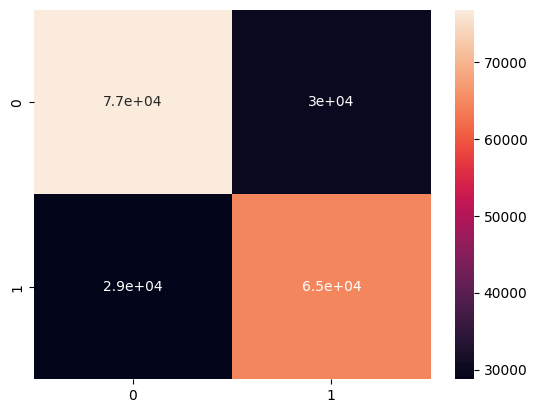

In [ ]:
knn = KNeighborsClassifier(n_neighbors=100)

knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)

df_result = metrics_score('KNN, hyperparam', y_test, y_pred_test)

## Decision Trees

              precision    recall  f1-score   support

         0.0       0.64      0.63      0.64    106999
         1.0       0.58      0.59      0.58     93332

    accuracy                           0.61    200331
   macro avg       0.61      0.61      0.61    200331
weighted avg       0.61      0.61      0.61    200331



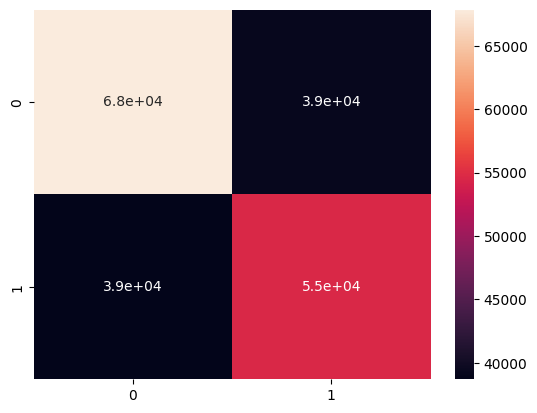

In [ ]:
dt = DecisionTreeClassifier()

dt.fit(X_train, y_train)
y_pred_test = dt.predict(X_test)

df_result = metrics_score('Decision Trees', y_test, y_pred_test)

**Подбор гиперпараметров**

Время работы 15:20, результаты:

> The best value = {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 100} with 0.7063439421318383 of accuracy.

> The best max_depth value, rank 226, with max_depth = {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 10}, highest mean accuracy along with the cross validation = 0.6694149823243833 and lowest standard deviation = 0.0003699168564464199

> The best classifier is: DecisionTreeClassifier(max_depth=8, min_samples_leaf=100, random_state=25)

In [ ]:
parameters = {'criterion':['gini','entropy'],
              'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
              'min_samples_leaf': [5, 10, 20, 50, 75, 100],}

default_tr = DecisionTreeClassifier(random_state=25)

grid = GridSearchCV(default_tr, parameters, cv=3, n_jobs=-1,verbose=1)
grid.fit(X_train, y_train)

grid_results(grid)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
The best value = {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 100} with 0.7063439421318383 of accuracy.
The best max_depth value, rank 226, with max_depth = {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 10}, highest mean accuracy along with the cross validation = 0.6694149823243833 and lowest standard deviation = 0.0003699168564464199
The best classifier is: DecisionTreeClassifier(max_depth=8, min_samples_leaf=100, random_state=25)


              precision    recall  f1-score   support

         0.0       0.72      0.73      0.73    106999
         1.0       0.69      0.68      0.68     93332

    accuracy                           0.71    200331
   macro avg       0.71      0.71      0.71    200331
weighted avg       0.71      0.71      0.71    200331



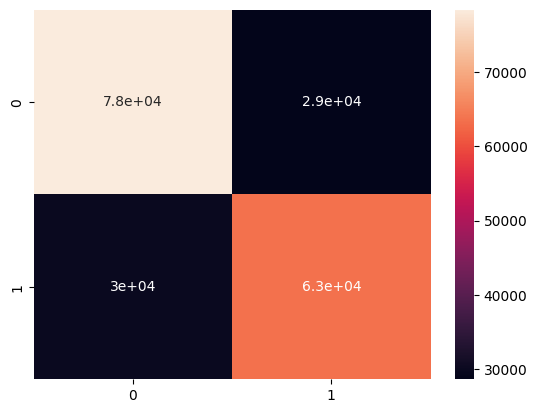

In [ ]:
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=100, random_state=25)

dt.fit(X_train, y_train)
y_pred_test = dt.predict(X_test)

df_result = metrics_score('Decision Trees, hyperparams', y_test, y_pred_test)

## SVM

              precision    recall  f1-score   support

         0.0       0.51      0.74      0.61    106999
         1.0       0.39      0.19      0.26     93332

    accuracy                           0.49    200331
   macro avg       0.45      0.47      0.43    200331
weighted avg       0.46      0.49      0.44    200331



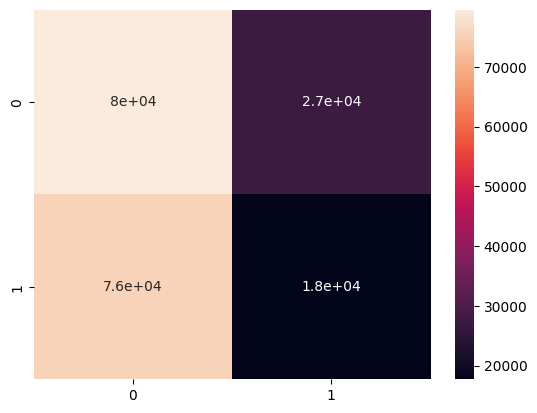

In [ ]:
svc = SVC(max_iter = 100)

svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)

df_result = metrics_score('SVC 100', y_test, y_pred_test)

              precision    recall  f1-score   support

         0.0       0.41      0.42      0.42    106999
         1.0       0.31      0.30      0.31     93332

    accuracy                           0.37    200331
   macro avg       0.36      0.36      0.36    200331
weighted avg       0.37      0.37      0.37    200331



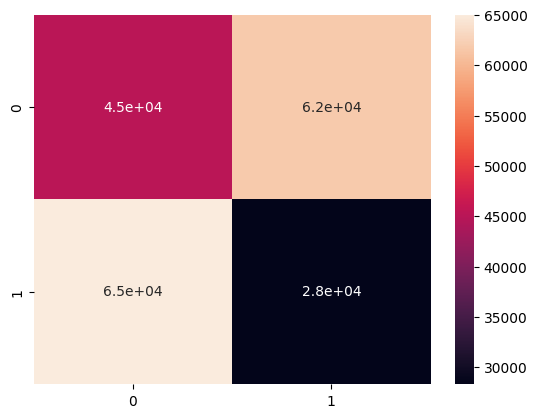

In [ ]:
svc = SVC(max_iter = 1000)

svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)

df_result = metrics_score('SVC 1000', y_test, y_pred_test)

**Подбор гиперпараметров**


Для max_iter = 100 время работы 13:35, результаты:

> The best value = {'C': 100, 'gamma': 0.3, 'kernel': 'rbf'} with 0.545999756269491 of accuracy.

> The best value = {'C': 100, 'gamma': 0.3, 'kernel': 'rbf'}, highest mean accuracy along with the cross validation = 0.545999756269491 and lowest standard deviation = 0.12075480693274142

> The best classifier is: SVC(C=100, gamma=0.3, max_iter=100)

Для max_iter = 1000 время работы 2:04:17, результаты:

> The best value = {'C': 1000, 'gamma': 0.7, 'kernel': 'rbf'} with 0.6164004811653321 of accuracy.

> The best value = {'C': 1000, 'gamma': 0.7, 'kernel': 'rbf'}, highest mean accuracy along with the cross validation = 0.6164004811653321 and lowest standard deviation = 0.027785302756909307

> The best classifier is: SVC(C=1000, gamma=0.7, max_iter=1000)

In [ ]:
svc = SVC(max_iter = 1000)
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'],
                'gamma':[0.1, 0.3, 0.5, 0.7, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,
                'gamma':[0.01,0.03,0.05]}]

grid = GridSearchCV(svc, parameters, cv=3, n_jobs=-1,verbose=1)
grid.fit(X_train, y_train)

grid_results(grid)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
The best value = {'C': 1000, 'gamma': 0.7, 'kernel': 'rbf'} with 0.6164004811653321 of accuracy.
The best value = {'C': 1000, 'gamma': 0.7, 'kernel': 'rbf'}, highest mean accuracy along with the cross validation = 0.6164004811653321 and lowest standard deviation = 0.027785302756909307
The best classifier is: SVC(C=1000, gamma=0.7, max_iter=1000)


              precision    recall  f1-score   support

         0.0       0.64      0.44      0.52    106999
         1.0       0.52      0.71      0.61     93332

    accuracy                           0.57    200331
   macro avg       0.58      0.58      0.56    200331
weighted avg       0.58      0.57      0.56    200331



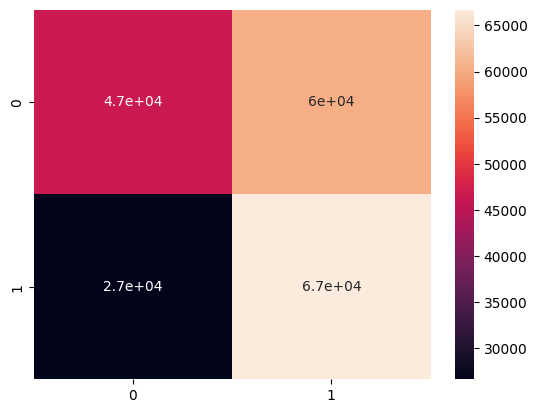

In [ ]:
svc = SVC(C=100, gamma=0.3, max_iter=100)

svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)

df_result = metrics_score('SVC 100, hyperparams', y_test, y_pred_test)

              precision    recall  f1-score   support

         0.0       0.64      0.45      0.53    106999
         1.0       0.53      0.71      0.61     93332

    accuracy                           0.57    200331
   macro avg       0.59      0.58      0.57    200331
weighted avg       0.59      0.57      0.57    200331



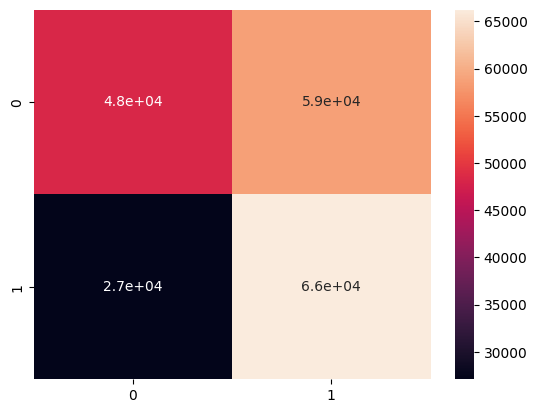

In [ ]:
svc = SVC(C=1000, gamma=0.7, max_iter=1000)

svc.fit(X_train, y_train)
y_pred_test = svc.predict(X_test)

df_result = metrics_score('SVC 1000, hyperparams', y_test, y_pred_test)

## MLP

              precision    recall  f1-score   support

         0.0       0.74      0.71      0.72    106999
         1.0       0.68      0.71      0.69     93332

    accuracy                           0.71    200331
   macro avg       0.71      0.71      0.71    200331
weighted avg       0.71      0.71      0.71    200331



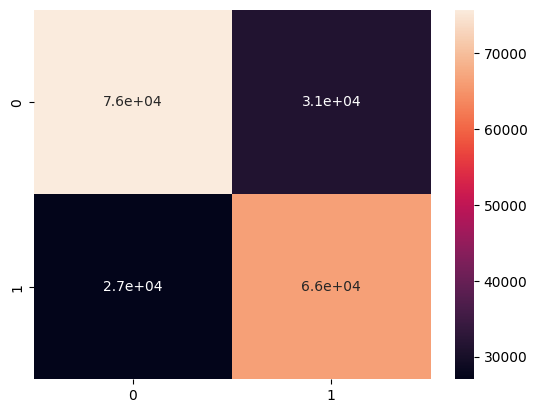

In [ ]:
mlp = MLPClassifier()

mlp.fit(X_train, y_train)
y_pred_test = mlp.predict(X_test)

df_result = metrics_score('MLP', y_test, y_pred_test)

Подбор гиперпараметров

Время работы 39:01, результаты:

> The best value = {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'adam'} with 0.7099658120114748 of accuracy.

> The best value = {'activation': 'relu', 'learning_rate': 'adaptive', 'solver': 'adam'}, highest mean accuracy along with the cross validation = 0.7099658120114748 and lowest standard deviation = 0.0010489324623151179

> The best classifier is: MLPClassifier(learning_rate='adaptive')

In [ ]:
parameters = {'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],
              'alpha': [0.0001, 0.05],
              'learning_rate': ['constant','adaptive']}

grid = GridSearchCV(mlp, parameters, cv=3, n_jobs=-1,verbose=1)
grid.fit(X_train, y_train)

grid_results (grid)

              precision    recall  f1-score   support

         0.0       0.74      0.70      0.72    106999
         1.0       0.68      0.72      0.70     93332

    accuracy                           0.71    200331
   macro avg       0.71      0.71      0.71    200331
weighted avg       0.71      0.71      0.71    200331



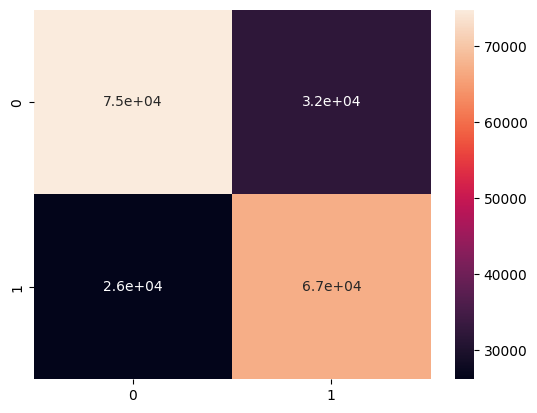

In [ ]:
mlp = MLPClassifier(learning_rate='adaptive')

mlp.fit(X_train, y_train)
y_pred_test = mlp.predict(X_test)

df_result = metrics_score('MLP, hyperparams', y_test, y_pred_test)

## Логистическая регрессия

              precision    recall  f1-score   support

         0.0       0.71      0.76      0.73    106999
         1.0       0.70      0.64      0.67     93332

    accuracy                           0.70    200331
   macro avg       0.70      0.70      0.70    200331
weighted avg       0.70      0.70      0.70    200331



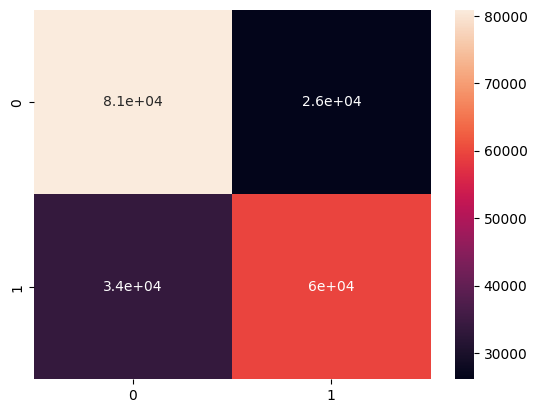

In [ ]:
lreg = LogisticRegression()

lreg.fit(X_train, y_train)
y_pred_test = lreg.predict(X_test)

df_result = metrics_score('Logistic Regression', y_test, y_pred_test)

**Подбор гиперпараметров**

Время работы 28:16, результаты:

> The best value = {'C': 4.281332398719396, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'} with 0.7020567433423182 of accuracy.

> The best value = {'C': 4.281332398719396, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}, highest mean accuracy along with the cross validation = 0.7020567433423182 and lowest standard deviation = 0.0011214169523653407

> The best classifier is: LogisticRegression(C=4.281332398719396, penalty='l1', solver='saga')

In [ ]:
parameters = [{'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
               'C' : np.logspace(-4, 4, 20),
               'solver' : ['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'],
               'max_iter' : [100]}]

grid = GridSearchCV(lreg, parameters, cv=3, n_jobs=-1,verbose=1)
grid.fit(X_train, y_train)

grid_results (grid)

              precision    recall  f1-score   support

         0.0       0.71      0.76      0.73    106999
         1.0       0.70      0.64      0.67     93332

    accuracy                           0.70    200331
   macro avg       0.70      0.70      0.70    200331
weighted avg       0.70      0.70      0.70    200331



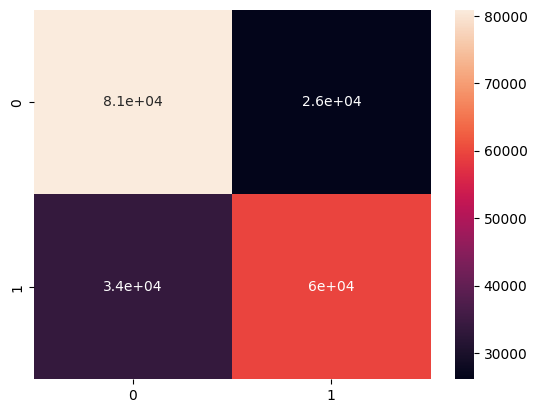

In [ ]:
lreg = LogisticRegression(C=4.281332398719396, penalty='l1', solver='saga')

lreg.fit(X_train, y_train)
y_pred_test = lreg.predict(X_test)

df_result = metrics_score('Logistic Regression, hyperparams', y_test, y_pred_test)

## Результаты для классического подхода

In [ ]:
df_result.sort_values(by=['Accuracy'], ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,f1_0,f1_1,error,% error %
8,MLP,0.70934,0.71054,0.70934,0.70963,0.722435,0.694940,58229,29.066395
9,"MLP, hyperparams",0.70891,0.71085,0.70891,0.70924,0.719633,0.697328,58315,29.109324
3,"Decision Trees, hyperparams",0.70759,0.70737,0.70759,0.70745,0.727880,0.684028,58579,29.241106
1,"KNN, hyperparam",0.70576,0.70610,0.70576,0.70589,0.722642,0.686694,58945,29.423804
11,"Logistic Regression, hyperparams",0.70176,0.70137,0.70176,0.70056,0.730303,0.666469,59746,29.823642
10,Logistic Regression,0.70173,0.70133,0.70173,0.70053,0.730282,0.666414,59753,29.827136
0,KNN,0.66536,0.66548,0.66536,0.66541,0.686010,0.641800,67039,33.464117
2,Decision Trees,0.61132,0.61145,0.61132,0.61138,0.635369,0.583882,77864,38.867674
7,"SVC 1000, hyperparams",0.57166,0.58910,0.57166,0.56556,0.529502,0.606891,85809,42.833610
6,"SVC 100, hyperparams",0.56581,0.58461,0.56581,0.55842,0.517488,0.605340,86981,43.418642


# Ансамблевые методы

## Стекинг

              precision    recall  f1-score   support

         0.0       0.71      0.72      0.72    106999
         1.0       0.68      0.66      0.67     93332

    accuracy                           0.69    200331
   macro avg       0.69      0.69      0.69    200331
weighted avg       0.69      0.69      0.69    200331



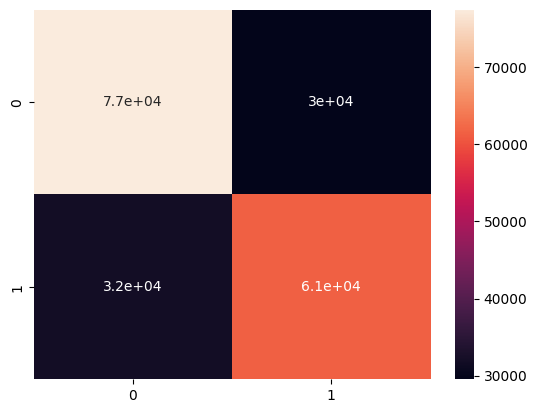

In [ ]:
base_estimators = [
    ('rand', RandomForestClassifier(random_state=42)),
    ('svc', SVC(max_iter = 1000, random_state=42))]

final_estimator = LogisticRegression()

stack_clf = StackingClassifier(estimators = base_estimators,
                               final_estimator = final_estimator)

stack_clf.fit(X_train, y_train)
y_pred_test = stack_clf.predict(X_test)

df_result = metrics_score('Stacking (forest+svc)', y_test, y_pred_test)

              precision    recall  f1-score   support

         0.0       0.71      0.76      0.74    106999
         1.0       0.70      0.65      0.68     93332

    accuracy                           0.71    200331
   macro avg       0.71      0.70      0.71    200331
weighted avg       0.71      0.71      0.71    200331



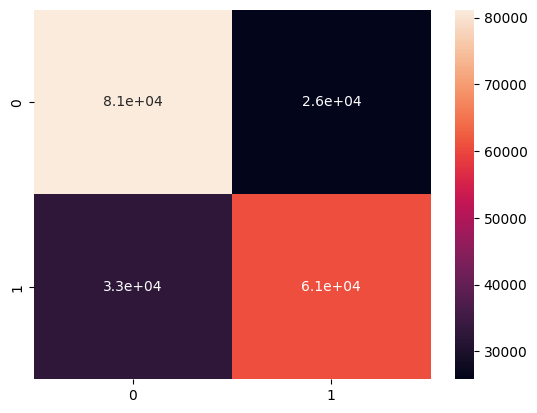

In [ ]:
base_estimators = [
    ('mlp', MLPClassifier()),
    ('tree', DecisionTreeClassifier(max_depth=8, min_samples_leaf=100, random_state=25))]

final_estimator = LogisticRegression()
stack_clf = StackingClassifier(estimators = base_estimators,
                               final_estimator = final_estimator)

stack_clf.fit(X_train, y_train)
y_pred_test = stack_clf.predict(X_test)

df_result = metrics_score('Stacking (mlp+tree)', y_test, y_pred_test)

## Беггинг

              precision    recall  f1-score   support

         0.0       0.70      0.74      0.72    106999
         1.0       0.68      0.64      0.66     93332

    accuracy                           0.69    200331
   macro avg       0.69      0.69      0.69    200331
weighted avg       0.69      0.69      0.69    200331



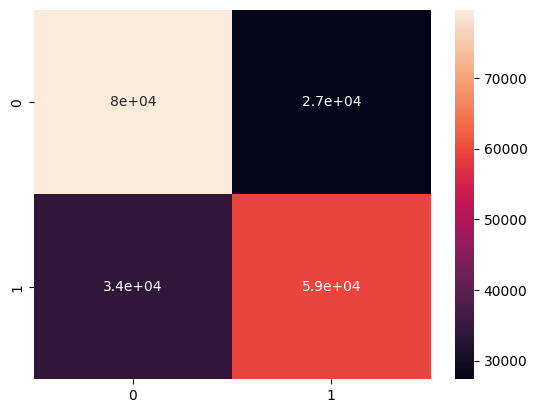

In [ ]:
bag_classifier = BaggingClassifier(
      DecisionTreeClassifier(max_depth=8, min_samples_leaf=100, random_state=25),
    max_samples=0.5, max_features=0.5, bootstrap=False)

bag_classifier.fit(X_train, y_train)
y_pred_test = bag_classifier.predict(X_test)

df_result = metrics_score('Bagging (DecisionTree)', y_test, y_pred_test)

              precision    recall  f1-score   support

         0.0       0.74      0.67      0.70    106999
         1.0       0.66      0.72      0.69     93332

    accuracy                           0.70    200331
   macro avg       0.70      0.70      0.70    200331
weighted avg       0.70      0.70      0.70    200331



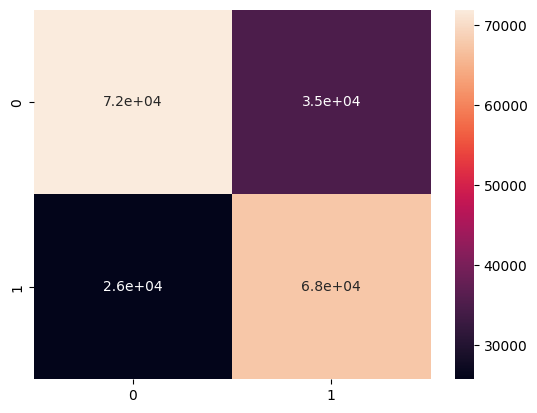

In [ ]:
bag_classifier = BaggingClassifier(
      DecisionTreeClassifier(max_depth=8, min_samples_leaf=100, random_state=25, class_weight='balanced'),
    max_samples=0.5, max_features=0.5, bootstrap=False)

bag_classifier.fit(X_train, y_train)
y_pred_test = bag_classifier.predict(X_test)

df_result = metrics_score('Bagging (DecisionTree balanced)', y_test, y_pred_test)

              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71    106999
         1.0       0.67      0.67      0.67     93332

    accuracy                           0.69    200331
   macro avg       0.69      0.69      0.69    200331
weighted avg       0.69      0.69      0.69    200331



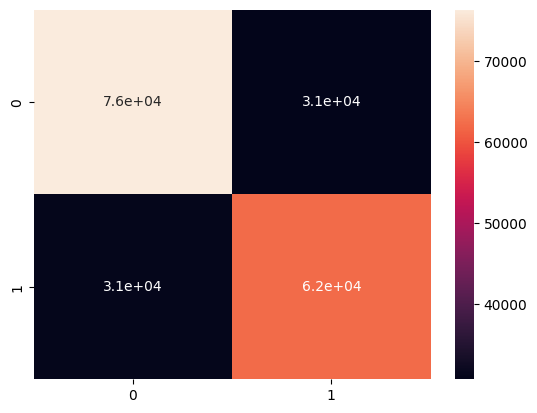

In [ ]:
rforest = RandomForestClassifier()

rforest.fit(X_train, y_train)
y_pred_test = rforest.predict(X_test)

df_result = metrics_score('RandomForest', y_test, y_pred_test)

## Бустинг

### GradientBoosting

              precision    recall  f1-score   support

         0.0       0.73      0.72      0.72    106999
         1.0       0.68      0.69      0.69     93332

    accuracy                           0.71    200331
   macro avg       0.71      0.71      0.71    200331
weighted avg       0.71      0.71      0.71    200331



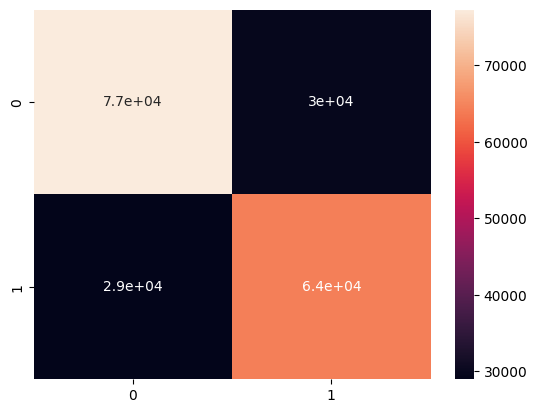

In [ ]:
grad_boost = GradientBoostingClassifier(
                        n_estimators=500,
                        learning_rate=0.8,
                        random_state=42)

grad_boost.fit(X_train, y_train)
y_pred_test = grad_boost.predict(X_test)

df_result = metrics_score('GradientBoosting', y_test, y_pred_test)

### AdaBoost

              precision    recall  f1-score   support

         0.0       0.72      0.72      0.72    106999
         1.0       0.68      0.68      0.68     93332

    accuracy                           0.70    200331
   macro avg       0.70      0.70      0.70    200331
weighted avg       0.70      0.70      0.70    200331



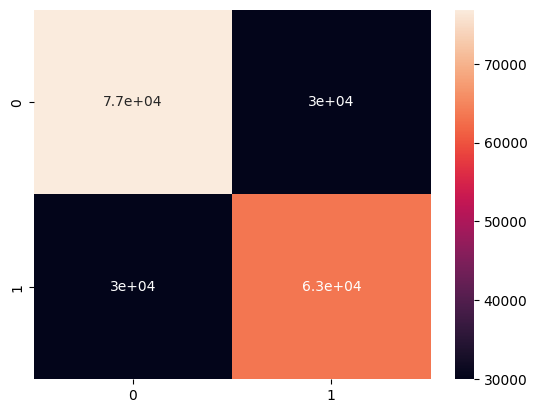

In [ ]:
adaboost = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=8, min_samples_leaf=100, random_state=25),
    n_estimators=300,
    learning_rate=0.5
)

adaboost.fit(X_train, y_train)
y_pred_test = adaboost.predict(X_test)

df_result = metrics_score('AdaBoost', y_test, y_pred_test)

### XGboost

              precision    recall  f1-score   support

         0.0       0.73      0.72      0.73    106999
         1.0       0.68      0.69      0.69     93332

    accuracy                           0.71    200331
   macro avg       0.71      0.71      0.71    200331
weighted avg       0.71      0.71      0.71    200331



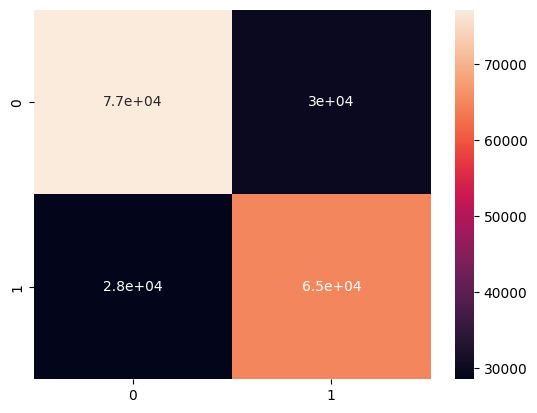

In [ ]:
xgb = xgb.XGBClassifier()

xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)

df_result = metrics_score('XGBoost', y_test, y_pred_test)

## Результаты для ансамблей

In [ ]:
df_result.sort_values(by=['Accuracy'], ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score,f1_0,f1_1,error,% error %
8,MLP,0.70934,0.71054,0.70934,0.70963,0.722435,0.694940,58229,29.066395
9,"MLP, hyperparams",0.70891,0.71085,0.70891,0.70924,0.719633,0.697328,58315,29.109324
19,XGBoost,0.70874,0.70905,0.70874,0.70886,0.725597,0.689681,58348,29.125797
13,Stacking (mlp+tree),0.70844,0.70805,0.70844,0.70742,0.735476,0.675255,58408,29.155747
3,"Decision Trees, hyperparams",0.70759,0.70737,0.70759,0.70745,0.727880,0.684028,58579,29.241106
17,GradientBoosting,0.70706,0.70722,0.70706,0.70713,0.724831,0.686835,58685,29.294018
1,"KNN, hyperparam",0.70576,0.70610,0.70576,0.70589,0.722642,0.686694,58945,29.423804
11,"Logistic Regression, hyperparams",0.70176,0.70137,0.70176,0.70056,0.730303,0.666469,59746,29.823642
10,Logistic Regression,0.70173,0.70133,0.70173,0.70053,0.730282,0.666414,59753,29.827136
18,AdaBoost,0.70013,0.70016,0.70013,0.70014,0.719049,0.678470,60074,29.987371
